# Content Analysis

Two main questions: how does language differ across provinces? And how does language differe over time.

In [1]:
from utils import DTYPE, PARSE_DATES, PROV_CONSOLIDATION, CONSOLIDATED_PROVINCES, CONVERTERS
from tqdm.auto import tqdm
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import glob

prov_map = lambda x : x if x not in PROV_CONSOLIDATION else PROV_CONSOLIDATION[x]

data_paths = glob.glob("../data/processed_data/2*.csv")
frames = [pd.read_csv(f,header=0,dtype=DTYPE,converters=CONVERTERS,parse_dates=PARSE_DATES) for f in tqdm(data_paths)]
total_df = pd.concat(frames, axis=0, ignore_index=True).set_index("id").sort_values("created_at")
total_df = total_df[~total_df.index.duplicated()]

total_df["created_at"] = total_df["created_at"].dt.to_period("D").dt.to_timestamp('s')
total_df["province"] = total_df["province"].apply(prov_map)
total_df = total_df[total_df.clean_text.notnull()]
print(len(total_df))
total_df.head()

/Users/cameron/.local/share/virtualenvs/COVID-Child-Care-Twitter-OW82RhPk/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


473805


,created_at,screen_name,source,clean_text,original_text,is_retweet,favorite_count,retweet_count,hashtags,urls,mentions,city,province,longitude,latitude
id,,,,,,,,,,,,,,,
1228469111451242497,2020-02-15,Transport_gc,Hootsuite Inc.,improve many priority pilot project important ...,Improving #RoadSafety in #Canada is one of our...,False,9,1,"[RoadSafety, Canada, seatbelts]",[https://twitter.com/i/web/status/122846911145...,,NaN,NaN,-113.64258,60.10867
1228470050996113408,2020-02-15,4Everanimalz1,Twitter for iPad,improve many priority pilot project important ...,Improving #RoadSafety in #Canada is one of our...,True,0,0,"[RoadSafety, Canada, seatbelts]",,[Transport_gc],Calgary,Alberta,-114.08529,51.05011
1228470466668564481,2020-02-15,Mom_ASDadvocate,Twitter for iPhone,student tcdsb would nice walk place know safe ...,"to me, a student in the TCDSB, this would be s...",True,0,0,,,[leahbanning],Toronto,Ontario,-79.41630,43.70011
1228470535530647552,2020-02-15,camille4change,Twitter for iPhone,student tcdsb would nice walk place know safe ...,"to me, a student in the TCDSB, this would be s...",True,0,0,,,[leahbanning],Hamilton,Ontario,-79.84963,43.25011
1228472099464810498,2020-02-15,DianneWatts4BC,Twitter for iPhone,still discuss pilot do already safety kid rid ...,Why is this still being discussed and piloted ...,False,27,4,,[https://twitter.com/i/web/status/122847209946...,,Surrey,British Columbia,-122.82509,49.10635


## Wordclouds

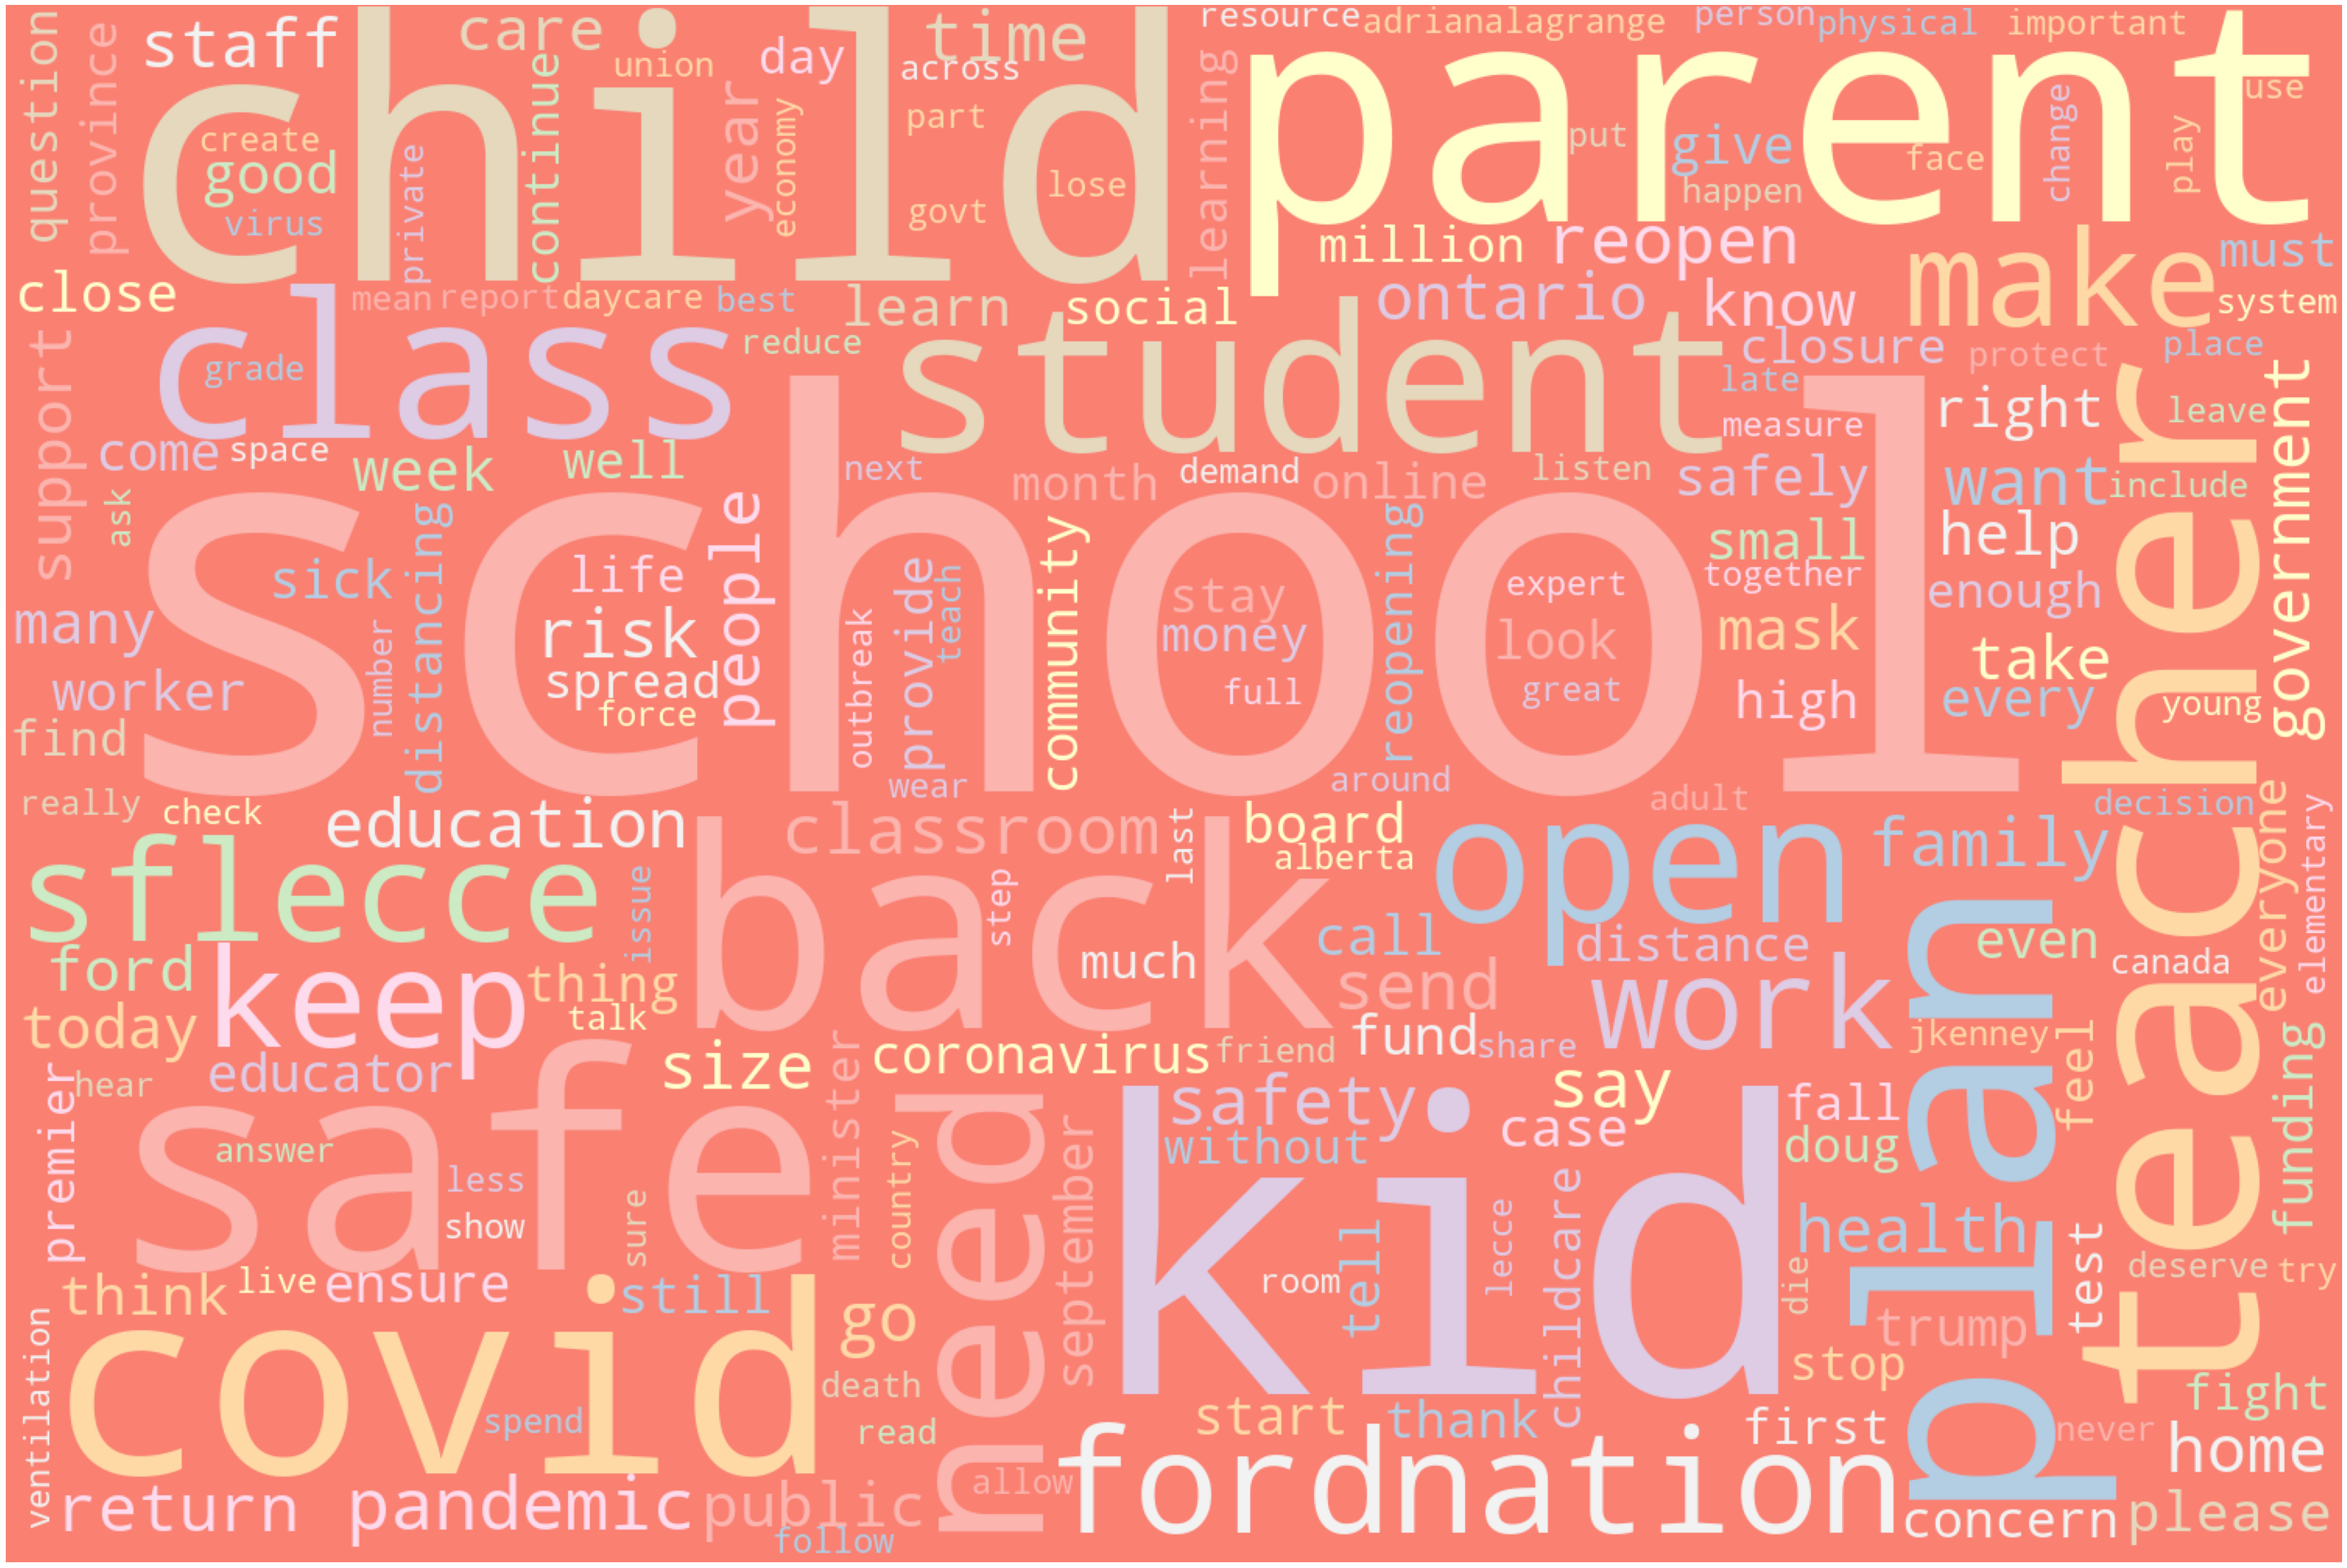

In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

text = ' '.join(total_df[total_df.clean_text.notnull()]['clean_text'])
wordcloud = WordCloud(width=1500,
                      height=1000,
                      random_state=1,
                      background_color='salmon',
                      colormap='Pastel1',
                      collocations=False,
                      stopwords=STOPWORDS).generate(text) # Plot
# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");
plt.tight_layout()

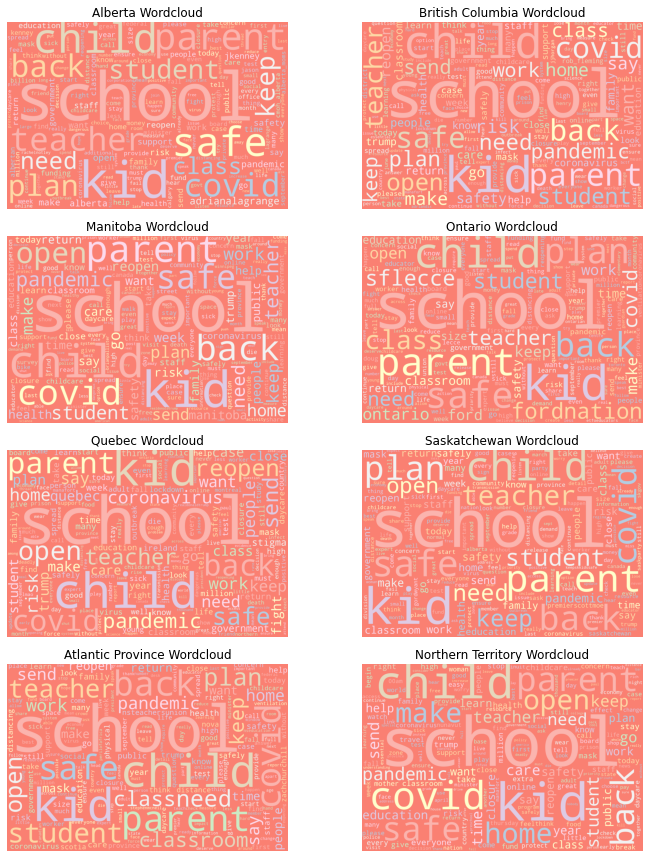

In [3]:
fig = plt.figure(figsize=(10,15))
for i,prov in enumerate(CONSOLIDATED_PROVINCES):
    ax = fig.add_subplot((len(CONSOLIDATED_PROVINCES)//2)+1,2,i+1)
    text = total_df[total_df.clean_text.notnull()]
    text = ' '.join(text[text["province"] == prov]["clean_text"])
    wordcloud = WordCloud(height=1000,
                          width=1500,
                          random_state=1,
                          background_color='salmon',
                          colormap='Pastel1',
                          collocations=False,
                          stopwords=STOPWORDS).generate(text)# Plot

    ax.imshow(wordcloud)
    ax.set_title(f"{prov} Wordcloud")
    ax.axis('off')
plt.tight_layout()
# plt.savefig("../visualizations/content_analysis/wordclouds/province_breakdown-wordcloud.png")

## Log Odds Ratio

Source: `Monroe, Burt L., Michael P. Colaresi, and Kevin M. Quinn. "Fightin'words: Lexical feature selection and evaluation for identifying the content of political conflict." Political Analysis 16, no. 4 (2008): 372-403.`

Odds for a word $w$ in a class of documents $i$ is $O^{(i)}_{w}=\frac{f^{(i)}_{w}}{(1-f^{(i)}_{w})}$

Odds ratio for two classes (candidates) would be $\theta^{(i_1 - i_2)}_{w} = \frac{O^{(i^1)}_{w}}{O^{(i^2)}_{w}}$

Log odds ratio would then be $log(\theta^{(i_1 - i_2)}_{w})$

By logging the odds ratio we can compare the odds ratio of words across classes


In [3]:
def filter_dict(a_dict,thresh=0.0001,n=None):
    if n:
        return {key: val for key,val in a_dict.items() if val/n > thresh}
    return {key: val for key,val in a_dict.items() if val > thresh}

to_odds = lambda x : (x/(1-x+0.001))
log_odds_ratio = lambda o1,o2 : np.log((o1+0.001)/(o2+0.001))

In [5]:
province_count = {}
province_prob = {}
total_df["clean_text"] = total_df["clean_text"].apply(lambda x : x.split())
for prov in CONSOLIDATED_PROVINCES:
    iso = total_df[total_df["province"] == prov]
    word_count = pd.Series(np.concatenate([x for x in iso["clean_text"]])).value_counts()
    n = word_count.sum()
    province_count[prov] = filter_dict(word_count.to_dict(),n=n)
    word_prob = filter_dict((word_count/n).to_dict())
    province_prob[prov] = word_prob

word_count = pd.Series(np.concatenate([x for x in total_df["clean_text"]])).value_counts()
n = word_count.sum()
province_count["Total"] = filter_dict(word_count.to_dict(),n=n,thresh=0)
word_prob = filter_dict((word_count/n).to_dict())
province_prob["Total"] = word_prob

province_count = pd.DataFrame.from_dict(province_count).fillna(0)
province_prob = pd.DataFrame.from_dict(province_prob).fillna(0)

province_count.index.name,province_prob.index.name = "word","word"
province_prob

,Alberta,British Columbia,Manitoba,Ontario,Quebec,Saskatchewan,Atlantic Province,Northern Territory,Total
word,,,,,,,,,
school,0.050409,0.055329,0.057237,0.046343,0.060766,0.058694,0.051666,0.056223,0.049354
kid,0.025715,0.026839,0.028302,0.021231,0.027490,0.029305,0.021236,0.030233,0.023461
child,0.016411,0.023871,0.023402,0.016438,0.028419,0.018756,0.021088,0.023515,0.018258
safe,0.015398,0.012253,0.012071,0.012203,0.008450,0.014603,0.010966,0.011492,0.012508
parent,0.013443,0.014454,0.014950,0.013390,0.013370,0.015932,0.012395,0.012199,0.013236
...,...,...,...,...,...,...,...,...,...
donwinslow,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000177,0.000000
fan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000177,0.000000
____________s,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000177,0.000000


In [ ]:
from utils import PROVINCE_COLOR_MAP

master_log_odds = province_prob.copy().applymap(lambda x : to_odds(x))

for prov in CONSOLIDATED_PROVINCES:
    master_log_odds[prov] = master_log_odds.apply(lambda x : log_odds_ratio(x[prov],x["Total"]),axis=1)
master_log_odds = master_log_odds.reset_index()
master_log_odds = master_log_odds.melt(id_vars=["word"], value_vars=CONSOLIDATED_PROVINCES,var_name="province",value_name="log_odds")
master_log_odds = master_log_odds.merge(province_count["Total"],how="left",left_on="word",right_index=True)

annotations = []
for prov in CONSOLIDATED_PROVINCES:
    iso = master_log_odds[master_log_odds["province"] == prov].sort_values("log_odds",ascending=False)
    annotations += [dict(x = np.log10(row["Total"]),
                        y = row["log_odds"],
                        text = row["word"]) 
                   for _,row in 
                   iso.head(3).iterrows() if row["Total"]>0]
xmax = master_log_odds["Total"].max()*0.9
ymax,ymin = master_log_odds["log_odds"].max()*1.1, master_log_odds["log_odds"].min()*1.1
annotations += [dict(x= np.log10(xmax),y=ymax,showarrow=False,text="<b>Province Specific</b>"),
                dict(x= np.log10(xmax),y=0,showarrow=False,text="<b>General Usage</b>"),
                dict(x= np.log10(xmax),y=ymin,showarrow=False,text="<b>Other Provinces</b>")]
    

fig = px.scatter(master_log_odds,
                 x="Total",
                 y="log_odds",
                 color="province",
                 hover_data=['word'],
                 opacity=0.5,
                 color_discrete_map=PROVINCE_COLOR_MAP,
                 labels={
                     "Total": "Word Frequency (All Provinces)",
                     "log_odds": "Log Odds Ratio Against All Provinces",
                     "subreddit": "Subreddit",
                     "word": "Word"
                 })
args = {
#     "font":{"size": 16},
    "template": "simple_white",
    "title": "Log Odds Ratio of Word Usage",
    "annotations": annotations,
    "height": 1000
}
fig.update_layout(**args)
fig.update_xaxes(type="log")
# fig.write_html("../visualizations/content_analysis/log_odds/all_provinces-log_odds_ratio.html")
fig.show()


In [ ]:
n = 20
for prov in CONSOLIDATED_PROVINCES:
    iso = master_log_odds[master_log_odds["province"] == prov].sort_values("log_odds",ascending=False)
    print(iso.head(n))

## Temporal Log Odds Ratio

For each province, what were the most disproportinately used words from Feb - May versus June to Now

In [ ]:
temporal_count = {}
temporal_prob = {}
def is_early(x):
    prov = x["province"]
    date = str(x["created_at"])
    return f"{prov}-early" if date < "2020-06-01 00:00:00" else f"{prov}-late"

temp_df = total_df[total_df["province"].isin(CONSOLIDATED_PROVINCES)]
temp_df["province"] = temp_df[["province","created_at"]].apply(is_early,axis=1)

provs = np.array([[f"{prov}-early",f"{prov}-late"] for prov in CONSOLIDATED_PROVINCES]).flatten()

for prov in provs:
    iso = temp_df[temp_df["province"] == prov]
    word_count = pd.Series(np.concatenate([x for x in iso["clean_text"]])).value_counts()
    n = word_count.sum()
    temporal_count[prov] = filter_dict(word_count.to_dict(),n=n)
    word_prob = filter_dict((word_count/n).to_dict())
    temporal_prob[prov] = word_prob

word_count = pd.Series(np.concatenate([x for x in temp_df["clean_text"]])).value_counts()
n = word_count.sum()
temporal_count["Total"] = filter_dict(word_count.to_dict(),n=n,thresh=0)
word_prob = filter_dict((word_count/n).to_dict())
temporal_prob["Total"] = word_prob

temporal_count = pd.DataFrame.from_dict(temporal_count).fillna(0)
temporal_prob = pd.DataFrame.from_dict(temporal_prob).fillna(0)

temporal_count.index.name,temporal_prob.index.name = "word","word"
temporal_prob

In [ ]:
from plotly.subplots import make_subplots

common_words = {}

num_rows = len(CONSOLIDATED_PROVINCES)//2
fig = make_subplots(
    rows=num_rows, cols=2,
    subplot_titles=(CONSOLIDATED_PROVINCES))


annotations = []
for i,prov in enumerate(CONSOLIDATED_PROVINCES):
    iso_count,iso_prob = temporal_count[[f"{prov}-early",f"{prov}-late"]],temporal_prob[[f"{prov}-early",f"{prov}-late"]]
    iso_prob.applymap(lambda x : to_odds(x))
    iso_prob["log_odds"] = iso_prob.apply(lambda x : log_odds_ratio(x[f"{prov}-early"],x[f"{prov}-late"]),axis=1)
    iso_prob = iso_prob[np.isfinite(iso_prob).all(1)]
    iso_prob["Total"] = iso_count.sum(axis=1)
    iso_prob = iso_prob.reset_index().sort_values("log_odds")
    
    r, c = (i//2)+1,(i%2)+1
    
    fig.add_trace(go.Scatter(x=iso_prob["Total"],
                             y=iso_prob["log_odds"],
                             text=iso_prob["word"],
                             name=prov,
                             legendgroup=prov,
                             marker=dict(color=PROVINCE_COLOR_MAP[prov],opacity=0.5), 
                             mode="markers"),
                  row=r,
                  col=c)
    annotations += [dict(x = np.log10(row["Total"]),
                        y = row["log_odds"],
                        text = row["word"],
                        xref=f"x{i+1}" if i else "x",
                        yref=f"y{i+1}" if i else "y") 
                   for _,row in 
                   iso_prob.head(2).iterrows()]
    
    common_words[f"{prov}-Summer"] = list(iso_prob["word"].head(15))
    common_words[f"{prov}-Spring"] = list(iso_prob["word"].tail(15))

   
  
fig.update_xaxes(type="log")
fig.update_yaxes(title_text="Log Odds Ratio", col=1)
fig.update_xaxes(title_text="Word Frequency",row=num_rows)
fig.update_layout(font=dict(size=17),title_text="<b>Word Usage in Spring/Summer</b>",height=1000,annotations=annotations)
# fig.write_html("../visualizations/content_analysis/log_odds/temporal-log_odds_ratio.html")

fig.show()


In [ ]:
pd.DataFrame.from_dict(common_words).to_csv("../data/common_words.csv")

# Clustering Short Text Data

## Semi-supervised Topic Modelling

Source: https://medium.com/pew-research-center-decoded/overcoming-the-limitations-of-topic-models-with-a-semi-supervised-approach-b947374e0455

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
sample = total_df.sample(1000,random_state=2)
vectorizer = TfidfVectorizer(
    max_df=.5,
    min_df=10,
    max_features=None,
    ngram_range=(1, 2),
    norm=None,
    binary=True,
    sublinear_tf=False
)
vectorizer = vectorizer.fit(sample['clean_text'])
tfidf = vectorizer.transform(sample['clean_text'])
vocab = vectorizer.get_feature_names()
print(len(sample),len(vocab))

1000 366


In [74]:
from corextopic import corextopic as ct

anchors = [["mask", "class size","small class","reduce class","physical distancing", "ppe"],
           ["public school","private school","public","private","resources","resource gap"],
           ["childcare","daycare", "toddler"],
           ["remote work", "zoom meeting","essential work", "essential workers","work","wfh"],
           ["online","remote","distance","online learning","remote learning","distance learning", "zoom"],
           ["reopen","reopening school","school reopening","open schools", "open school","back school", "go back"],
           ["close","closure","close school","close schools"]]


### Train model on full dataset

In [75]:
n_hidden=12
anchor_strength = 4
vectorizer = TfidfVectorizer(
    max_df=.7,
    min_df=10,
    max_features=None,
    ngram_range=(1, 2),
    norm=None,
    binary=True,
    sublinear_tf=False
)
vectorizer = vectorizer.fit(total_df['clean_text'])
tfidf = vectorizer.transform(total_df['clean_text'])
vocab = vectorizer.get_feature_names()
print(tfidf.shape[0],len(vocab))
model = ct.Corex(n_hidden=n_hidden, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    docs=total_df['original_text'],
    anchors=anchors,
    anchor_strength=anchor_strength
)
print(f"Total Correlation for model: {model.tc}")
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

473805 116853
Total Correlation for model: 24.337632897524262
Topic #1: class size, mask, small class, size, reduce class, physical distancing, class, small, distancing, physical
Topic #2: public, public school, private, private school, public health, public education, health, kid private, system, kid public
Topic #3: childcare, daycare, test positive, child care, positive, test, centre, care, positive covid, care centre
Topic #4: work, back work, work parent, work school, parent work, work child, return work, work home, people back, work together
Topic #5: distance, online, remote, zoom, online learning, distance learning, remote learning, learning, learn, person discuss
Topic #6: back school, reopen, back, open school, go back, school, kid back, school reopen, reopening school, reopen school
Topic #7: close, closure, school closure, close school, school close, parent guardian, guardian, meal, remain, closed
Topic #8: need pack, retweet teacher, ontarians retweet, need loud, right tha

In [76]:
for i,tweets in enumerate(model.get_top_docs()):
    print(f"\t\t--------- Topic {i+1} ---------")
    for tweet in list(zip(*tweets))[0]:
        print(f"*{tweet}")
    print("///\n")
    

		--------- Topic 1 ---------
*Honestly, now even the OMA is calling for improvements to the Ford/Lecce plan. Fewer and fewer people are saying that the plan will ensure a #SafeSeptember. Today's funding announcement allows the government to do the right thing - they have no excuses. https://t.co/iJISWutoN8
*Dear @fordnation and @Sflecce. 

You are cordially invited to visit our Kindergarten classroom on the first day of school. We are expecting 29 students who will not be wearing masks.

Looking forward to seeing you on September 8!

#UnsafeSeptember #OntEd
*Here’s an open video letter to @fordnation and @Sflecce on the importance of smaller classes 

#SmallerIsSafer #SafeSeptemberON @msiggerslibrary 

https://t.co/6NUb8xEE79
*#Alberta with another 113 cases of #COVID19 and 5 more deaths. Just imagine this is before we start piling kids in classrooms of 30 to 35 students without masks. What could ever go wrong with that. Imagine a child finding out they gave COVID to a parent? #VeryWo

Text(0, 0.5, 'Total Correlation (nats)')

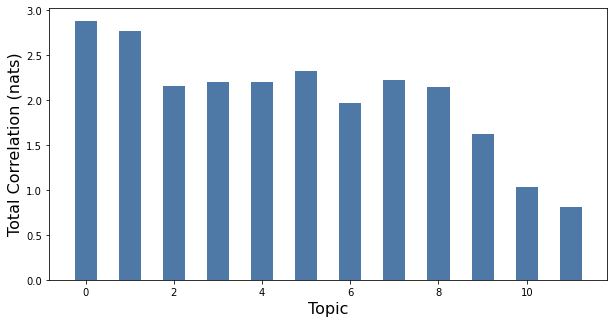

In [77]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)

In [78]:
from corextopic import vis_topic as vt
 
vt.vis_rep(model, row_label=total_df.index, column_label=vocab, prefix='../data/processed_data/cortex_summary')

Print topics in text file


# Analyze 